In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
%matplotlib inline

In [4]:
with open("quant_reg_learned_160826-221954_results.json", "r") as f:
    quantreg_results = json.load(f)
    
####### NOTE: This is with batching with a 95% backoff!!!    
# with open("quant_reg_aimd_160826-222354_results.json", "r") as f:
#     aimd_results = json.load(f)
#######

# NOTE: This is with batching with a 10% backoff
with open("quant_reg_aimd_160826-230417_results.json", "r") as f:
    aimd_results = json.load(f)
    

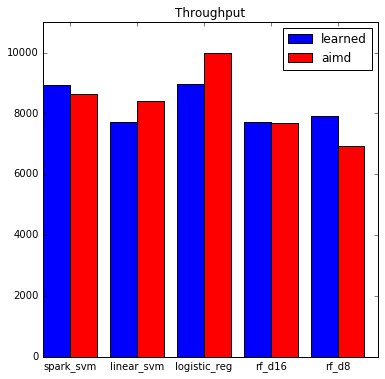

In [10]:
thrus = [(m["name"].split(":")[0], m["rate"]) for m in quantreg_results["meters"] if "model_thruput" in m["name"]]
names, rates = zip(*thrus)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(np.arange(len(rates))*5,  rates, width=2, color="blue", label="learned")
thrus = [(m["name"].split(":")[0], m["rate"]) for m in aimd_results["meters"] if "model_thruput" in m["name"]]
names, rates = zip(*thrus)
ax.bar(np.arange(len(rates))*5 + 2,  rates, width=2, color="red", label="aimd")
plt.xticks(np.arange(len(rates))*5 + 2, names)
ax.set_ylim(0, 11000)
ax.legend(loc=0)
ax.set_title("Throughput")



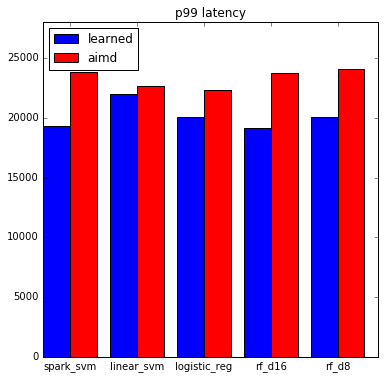

In [11]:
p99 = [(m["name"].split(":")[0], m["p99"]) for m in quantreg_results["histograms"] if "model_latency" in m["name"]]
names, lats = zip(*p99)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(np.arange(len(names))*5,  lats, width=2, color="blue", label="learned")

p99 = [(m["name"].split(":")[0], m["p99"]) for m in aimd_results["histograms"] if "model_latency" in m["name"]]
names, lats = zip(*p99)
ax.bar(np.arange(len(names))*5 + 2,  lats, width=2, color="red", label="aimd")
plt.xticks(np.arange(len(names))*5 + 2, names)
ax.set_ylim(0, 28000)
ax.legend(loc=0)
ax.set_title("p99 latency")

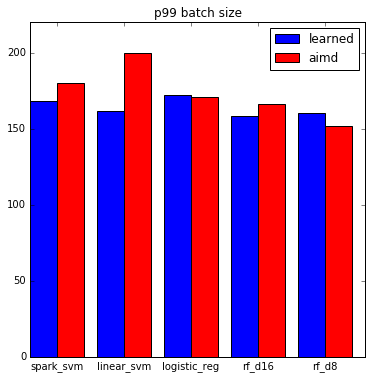

In [12]:
p99 = [(m["name"].split(":")[0], m["p99"]) for m in quantreg_results["histograms"] if "model_batch_size" in m["name"]]
names, lats = zip(*p99)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(np.arange(len(names))*5,  lats, width=2, color="blue", label="learned")

p99 = [(m["name"].split(":")[0], m["p99"]) for m in aimd_results["histograms"] if "model_batch_size" in m["name"]]
names, lats = zip(*p99)
ax.bar(np.arange(len(names))*5 + 2,  lats, width=2, color="red", label="aimd")
plt.xticks(np.arange(len(names))*5 + 2, names)
ax.set_ylim(0, 220)
ax.legend(loc=0)
ax.set_title("p99 batch size")

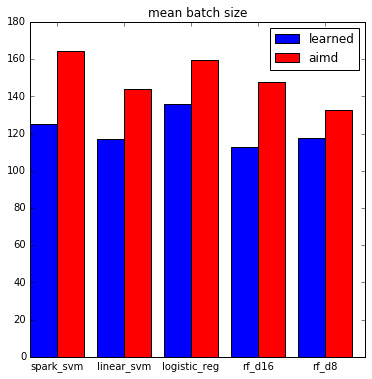

In [8]:
mean = [(m["name"].split(":")[0], m["mean"]) for m in quantreg_results["histograms"] if "model_batch_size" in m["name"]]
names, lats = zip(*mean)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(np.arange(len(names))*5,  lats, width=2, color="blue", label="learned")

mean = [(m["name"].split(":")[0], m["mean"]) for m in aimd_results["histograms"] if "model_batch_size" in m["name"]]
names, lats = zip(*mean)
ax.bar(np.arange(len(names))*5 + 2,  lats, width=2, color="red", label="aimd")
plt.xticks(np.arange(len(names))*5 + 2, names)
# ax.set_ylim(0, )
ax.legend(loc=0)
ax.set_title("mean batch size")